# M1N Folkersma, pt 2

Workflow to create a network from Folkersma data.
* Part 1 (Python): from raw data to QGIS input
* Part 2 (QGIS): from QGIS input to nx input
* **Part 3 (Python): from nx input to graph object**

## Step 3

In [1]:
# Load libraries
import os
import pandas as pd
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiLineString
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import momepy
import numpy as np
# import math
import contextily as cx
from src import graphedit

**0. Define proj crs!!**

In [2]:
proj_crs = "EPSG:25832"

**1. Import file genereated by QGIS workflow in Step 2**
(cf. previous notebook)

In [3]:
gdf = gpd.read_file("../../data/folkersma/processed/qgis_output.gpkg")
gdf = gdf.explode(index_parts = False)
gdf.head(3)

,rating,geometry
0,1.0,"LINESTRING (675365.070 6123560.480, 675365.580..."
1,1.0,"LINESTRING (674260.732 6124551.179, 674266.410..."
2,1.0,"LINESTRING (675150.640 6123856.800, 675154.050..."


**Process and check components**

comps: 4
degrees: [0, 113, 259, 1065, 134, 6, 1]


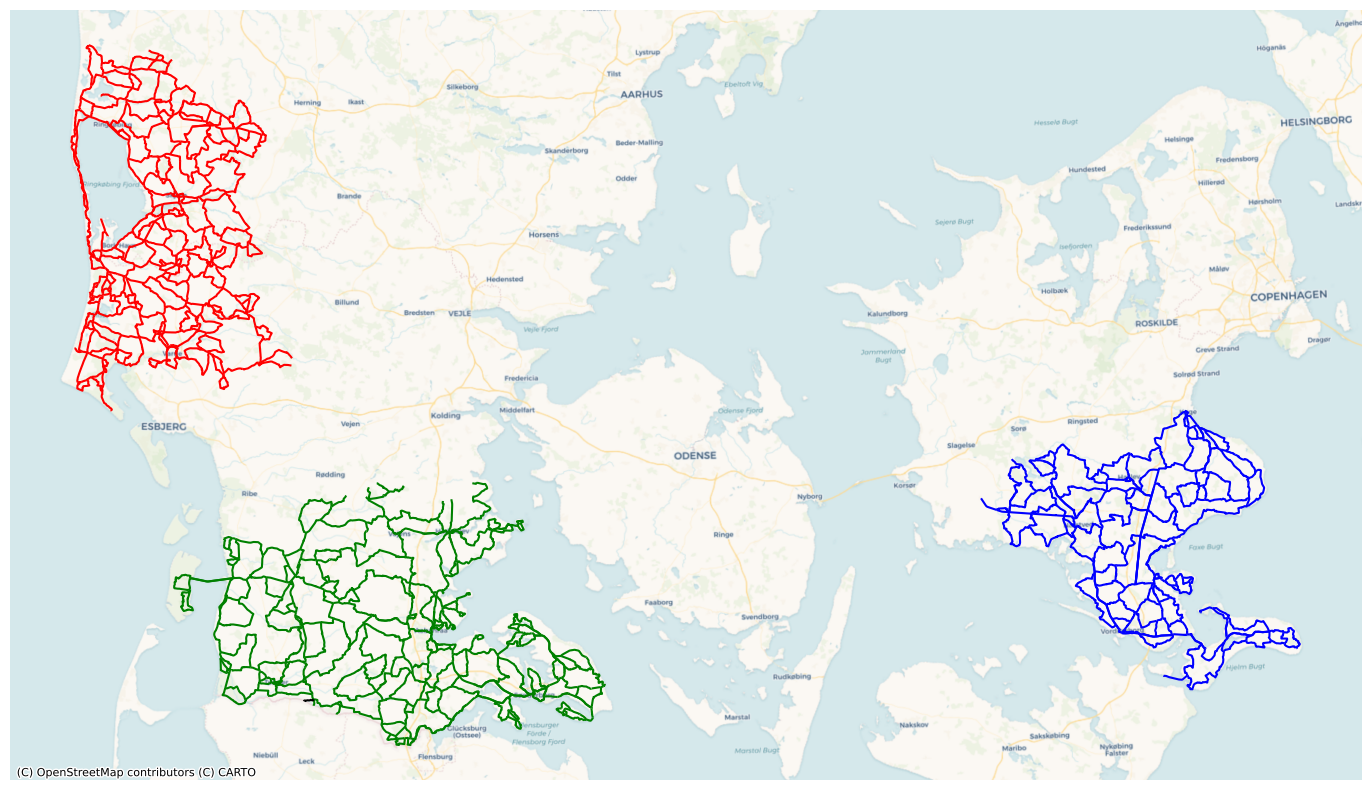

In [4]:
# get "noded" gdf
n = shapely.node(gdf.unary_union)
n = gpd.GeoDataFrame({"geometry": [n]}, crs = proj_crs)
n = n.explode(index_parts=False).reset_index(drop=True)
n["id"] = n.index

# make graph 
Gdir = momepy.gdf_to_nx(n)
G = Gdir.to_undirected()
print("comps:", len([c for c in nx.connected_components(G)]))
print("degrees:", nx.degree_histogram(G))

# plot components
geomdict = nx.get_edge_attributes(G, "geometry")

edges = gpd.GeoDataFrame(
    {
        "geometry": geomdict.values(), 
        "id" : geomdict.keys()
    },
    crs = proj_crs
)

edges["degrees"] = edges.apply(
    lambda x: 
        int(str(sorted([G.degree(x.id[0]), G.degree(x.id[1])])).replace("[", "").replace(", ", "").replace("]","")),
    axis = 1)

nodes = gpd.GeoDataFrame(
    {
        "geometry": [Point(node) for node in G.nodes],
        "id": list(G.nodes)
    },
    crs = proj_crs
)

nodes["degree"] = nodes.apply(lambda x: G.degree(x.id), axis = 1)

# edges[["geometry", "degrees"]].to_file("../qgis/folkersma/tempedges.gpkg", index = False)
# nodes[["geometry","degree"]].to_file("../qgis/folkersma/tempnodes.gpkg", index = False)

mycols = ["blue", "red", "green", "black", "black", "black"]

fig, ax = plt.subplots(1, 1, figsize = (20,10))

comps = [c for c in nx.connected_components(G)]

for j, comp in enumerate(comps):
    gpd.GeoDataFrame(
        geometry = list(nx.get_edge_attributes(
            nx.subgraph(G, comp), "geometry").values())).plot(
                ax = ax, color = mycols[j])
cx.add_basemap(ax = ax, crs=proj_crs, source=cx.providers.CartoDB.Voyager)
ax.set_axis_off()

**Save 3 LCCs as separate graphs**

In [5]:
G_stevns = nx.subgraph(G, comps[0]).copy()
G_aabenraa = nx.subgraph(G, comps[1]).copy()
G_skjern = nx.subgraph(G, comps[2]).copy()

**To save graphs, we need to convert some of the objects into strings (rather than LineString and CRS objects)**

(this is similar to what happens in osmnx.io.write_graphml, but with less steps)

In [6]:
myfilepath = "../../data/folkersma/processed/G_stevns.json"
graphedit.spatialgraph_tojson(
    G = G_stevns, 
    crs_string = proj_crs, 
    filepath = myfilepath
    )

myfilepath = "../../data/folkersma/processed/G_aabenraa.json"
graphedit.spatialgraph_tojson(
    G = G_aabenraa, 
    crs_string = proj_crs, 
    filepath = myfilepath
    )

myfilepath = "../../data/folkersma/processed/G_skjern.json"
graphedit.spatialgraph_tojson(
    G = G_skjern, 
    crs_string = proj_crs, 
    filepath = myfilepath
    )

# # to read graph back in, do:
# G = graphedit.spatialgraph_fromjson(
#     filepath = myfilepath
#     )

json serialized graph saved to ../../data/folkersma/processed/G_stevns.json
json serialized graph saved to ../../data/folkersma/processed/G_aabenraa.json
json serialized graph saved to ../../data/folkersma/processed/G_skjern.json


In [7]:
for myg in [G_stevns, G_skjern, G_aabenraa]:
    print(
        "edges:", len(myg.edges), 
        "; nodes:", len(myg.nodes), 
        "; degrees:", nx.degree_histogram(myg)
    )

edges: 567 ; nodes: 406 ; degrees: [0, 29, 78, 248, 50, 1]
edges: 885 ; nodes: 641 ; degrees: [0, 45, 127, 411, 53, 4, 1]
edges: 746 ; nodes: 529 ; degrees: [0, 37, 54, 406, 31, 1]


***
***